In [1]:
import torch
from torch import nn
import torch.nn.init as init

In [2]:
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms.v2 import Resize, ToTensor, Compose, Normalize

transforms =Compose([
    ToTensor(),
    Normalize(mean=(0,), std=(1,))
])

train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

class_names = train_data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 26421880/26421880 [00:01<00:00, 16948098.67it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272831.00it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4989559.63it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8745353.18it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
import matplotlib.pyplot as plt

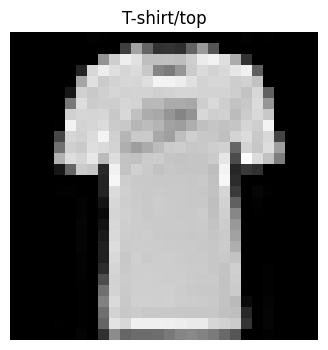

In [4]:
plt.figure(figsize=(5, 4))

random_idx = torch.randint(0, len(train_data), size=[1]).item()
img, label = train_data[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [6]:
class AlexNet(nn.Module):
    def __init__(self, in_channels=1, out_shape=10, activation_fn=nn.ReLU):
        super().__init__()
        self.activation_fn = activation_fn 
        self.block_1 = nn.Sequential( 
            nn.Conv2d(1, 64, kernel_size=3, padding=1), # 64x28x28
            activation_fn(),
            nn.MaxPool2d(kernel_size=3, stride=2), # 64x14x14
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128x14x14
            activation_fn(),
            nn.MaxPool2d(kernel_size=3, stride=2), # 128x7x7
            nn.Conv2d(128, 256, kernel_size=3, padding=1), activation_fn(), # 256x7x7
            nn.Conv2d(256, 256, kernel_size=3, padding=1), activation_fn(), # 256x7x7
            nn.MaxPool2d(kernel_size=3, stride=2), # 128x3x3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=1024),
            activation_fn(), nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=1024),
            activation_fn(), nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=out_shape),
        )
        dummy_input = torch.randn(1, 1, 28, 28) 
        _ = self(dummy_input)
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.block_1(x)
        x = self.classifier(x)

        return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
def train_step(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device="cpu"):
    model.to(device)
    model.train()
    train_loss = train_acc = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)

        loss = loss_fn(y_logits, y)

        train_loss += loss
        train_acc += accuracy_fn(y_logits.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss.detach().cpu().item(), train_acc


def test_step(model, train_dataloader, loss_fn, accuracy_fn, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = test_acc = 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_logits = model(X)
        
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_logits.argmax(dim=1), y)
    
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        return test_loss.detach().cpu().item(), test_acc

In [9]:
def accuracy_fn(y_pred, y_true):
    return torch.eq(y_pred, y_true).sum().item() / len(y_true)

# ReLU as activation func

In [10]:
from tqdm.auto import tqdm

model_0 = AlexNet(out_shape=len(class_names), activation_fn=nn.ReLU)

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005, nesterov=True)

epoches = 11

train_losses_0 = []
test_losses_0 = []
test_acc_0 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_0, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_0, test_dataloader, loss_fn, accuracy_fn, device)
    
    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_0.append(train_info[0])
    test_losses_0.append(test_info[0])
    test_acc_0.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.75204 | Train accuracy: 0.72%
Test loss: 0.41109 | Test accuracy: 0.85%
Epoche: 2
---------
Train loss: 0.33479 | Train accuracy: 0.88%
Test loss: 0.31165 | Test accuracy: 0.89%
Epoche: 4
---------
Train loss: 0.27453 | Train accuracy: 0.90%
Test loss: 0.28368 | Test accuracy: 0.90%
Epoche: 6
---------
Train loss: 0.24281 | Train accuracy: 0.91%
Test loss: 0.26491 | Test accuracy: 0.91%
Epoche: 8
---------
Train loss: 0.21193 | Train accuracy: 0.92%
Test loss: 0.25316 | Test accuracy: 0.91%
Epoche: 10
---------
Train loss: 0.19320 | Train accuracy: 0.93%
Test loss: 0.24408 | Test accuracy: 0.92%


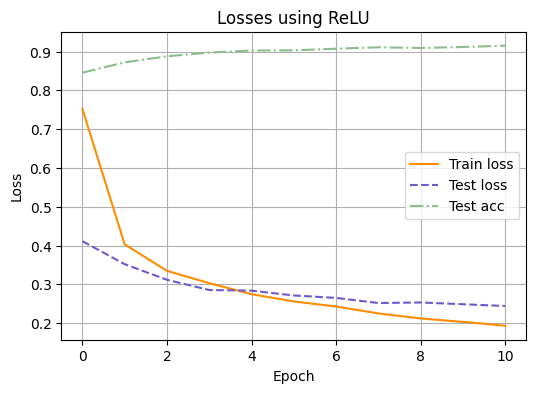

In [11]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_0, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_0, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_0, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses using ReLU")
plt.legend()
plt.grid(True)
plt.show()

# GELU as activation func

In [12]:
model_1 = AlexNet(out_shape=len(class_names), activation_fn=nn.GELU)

from tqdm.auto import tqdm

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005, nesterov=True)

epoches = 11

train_losses_1 = []
test_losses_1 = []
test_acc_1 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_1, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_1.append(train_info[0])
    test_losses_1.append(test_info[0])
    test_acc_1.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.74306 | Train accuracy: 0.72%
Test loss: 0.43697 | Test accuracy: 0.85%
Epoche: 2
---------
Train loss: 0.33992 | Train accuracy: 0.88%
Test loss: 0.31628 | Test accuracy: 0.89%
Epoche: 4
---------
Train loss: 0.27719 | Train accuracy: 0.90%
Test loss: 0.29336 | Test accuracy: 0.89%
Epoche: 6
---------
Train loss: 0.24037 | Train accuracy: 0.91%
Test loss: 0.26994 | Test accuracy: 0.90%
Epoche: 8
---------
Train loss: 0.21406 | Train accuracy: 0.92%
Test loss: 0.24812 | Test accuracy: 0.91%
Epoche: 10
---------
Train loss: 0.19059 | Train accuracy: 0.93%
Test loss: 0.23901 | Test accuracy: 0.91%


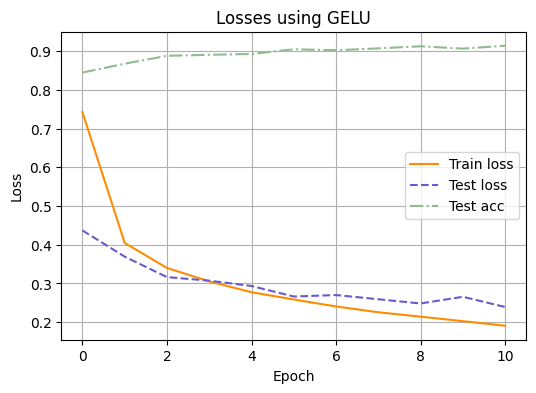

In [13]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_1, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_1, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_1, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses using GELU")
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

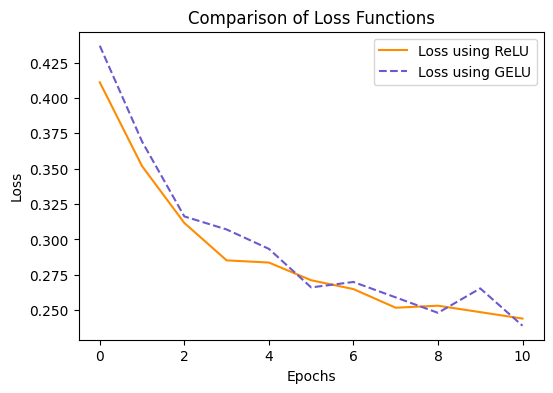

In [14]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), test_losses_0, c="darkorange", label="Loss using ReLU")
plt.plot(range(epoches), test_losses_1, c="slateblue", ls='dashed', label="Loss using GELU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Loss Functions")
plt.legend()
#plt.grid(True)
plt.show()
